In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from PyUoI.UoI_Lasso import UoI_Lasso

%matplotlib inline

In [2]:
datapath = 'data/20080516_R1.mat'

In [3]:
f = loadmat(datapath, struct_as_record=False)

In [4]:
sessions = f['stimulus'].ravel()
spikes = f['spikes']
n_cells = np.asscalar(np.asscalar(f['datainfo']).Ncell)

In [5]:
# choose recording number
recording = 0

# extract session
session = sessions[recording]

# number of frames
n_frames = np.asscalar(session.Nframes)
frame_length = np.asscalar(session.frame)
onset = np.asscalar(session.onset)

window_length = 0.5 # in seconds
n_frames_per_window = int(np.round(window_length/frame_length))

# timepoints
t = np.arange(n_frames) * frame_length + onset
N = t.size - 1

In [6]:
params = np.asscalar(session.param)
Nx = np.asscalar(params.x)/np.asscalar(params.dx)
Ny = np.asscalar(params.y)/np.asscalar(params.dy)
m = int(Nx * Ny)

In [7]:
m

640

In [8]:
responses = np.zeros((N, n_cells))
for cell in range(n_cells):
    spike_times = spikes[cell, recording]
    # bin spike train
    binned_spikes, _ = np.histogram(spike_times, bins=t)
    
    # put spikes in array
    binned_spikes[:n_frames_per_window-1] = 0
    n_spikes = np.sum(binned_spikes)
    
    responses[:, cell] = binned_spikes/n_spikes

In [9]:
byte = np.fromfile('ran1.bin', count=N*m//8, dtype='uint8')
stims = np.unpackbits(byte).astype('float32')
stims = 2 * stims - 1
stims = stims.reshape((N, m)).T

# STA

In [13]:
print(stims.shape)
print(m)

(640, 89898)
640


In [16]:
sta = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)

for window in range(n_frames_per_window):
    sta[window, :] = np.dot(stims, responses_copy[:, 0])
    print(r2_score(responses_copy[:, 0], np.dot(stims.T, sta[window, :])))
    responses_copy = np.roll(responses_copy, -1, axis=0)
    

-85987328.1234475
-86086716.98448694
-91827914.46852952
-93844020.61845738
-152272091.4511765
-289519143.92470336
-414965366.9323193
-342778174.9085117
-197557058.31457174
-96555979.60220174
-99477472.81512485
-138364526.34672767
-153721946.5619279
-174974599.1986464
-150450606.00343272
-132119083.62740563
-121740421.88397777
-119224104.967064
-107573451.63823704
-100693507.66564472
-90072299.69512448
-88865961.17702068
-83895225.39585444
-81422420.07164015
-79743412.3127406
-100017413.66395964
-92759984.98690651
-85314118.2840592
-79631323.61887531
-87721462.05498585


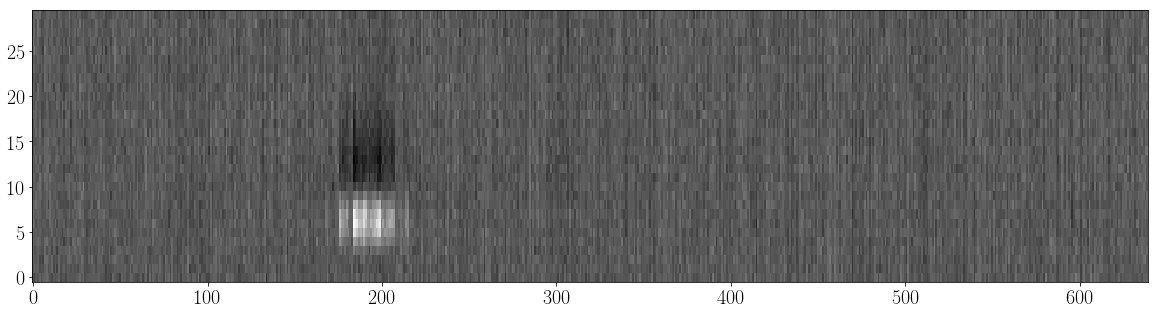

In [43]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(sta[:, :, 0], cmap='gray')
ax.set_aspect('auto')

# Linear Regression

In [17]:
ols_strf = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)

for window in range(n_frames_per_window):
    ols = LinearRegression(fit_intercept=True)
    ols.fit(stims.T, responses_copy[:, 0])
    ols_strf[window, :] = ols.coef_.T
    print(r2_score(responses_copy[:, 0], ols.predict(stims.T)))
    responses_copy = np.roll(responses_copy, -1, axis=0)

0.0076671074289452745
0.0073936537855129325
0.00800969195673329
0.008269089950220687
0.016592036389753373
0.03420414115545456
0.04894339648341006
0.04062628512218047
0.022017098366465593
0.008981233201366456
0.008502474538144456
0.012978305514865673
0.015143990129120377
0.017142105121672357
0.014415280056998325
0.012157794277200762
0.011069427933979803
0.010469941123635085
0.009180321581094164
0.008220333869184637
0.007587989066870304
0.0078026853455999134
0.006938621002163137
0.007088086251454961
0.00665602857130998
0.008509879261401121
0.007732838064125613
0.007206169260582707
0.00645079853880437
0.006771528437506724


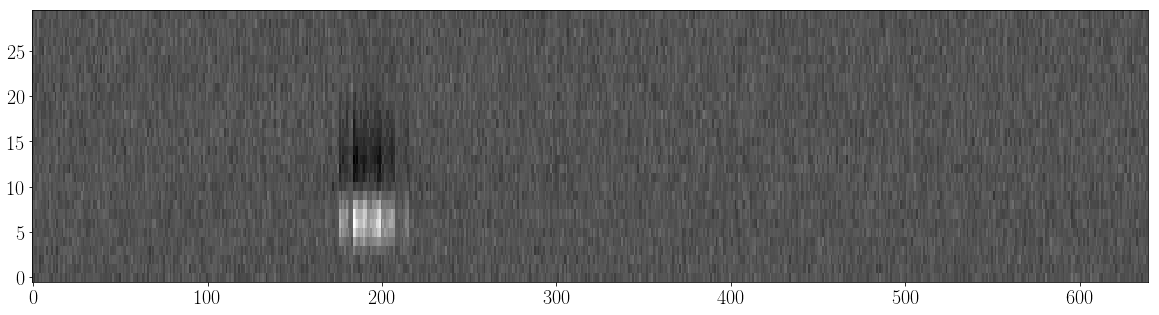

In [45]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(ols_strf[:, :], cmap='gray')
ax.set_aspect('auto')

# Ridge Regression

In [18]:
ridge_strf = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)

for window in range(n_frames_per_window):
    print(window)
    ridge = RidgeCV(
        cv=5
    )
    ridge.fit(stims.T, responses_copy[:, 0])
    ridge_strf[window, :] = ridge.coef_.T
    print(r2_score(responses_copy[:, 0], ridge.predict(stims.T)))
    responses_copy = np.roll(responses_copy, -1, axis=0)

0
0.007667106437377336
1
0.007393653100430164
2
0.008009690902444966
3


KeyboardInterrupt: 

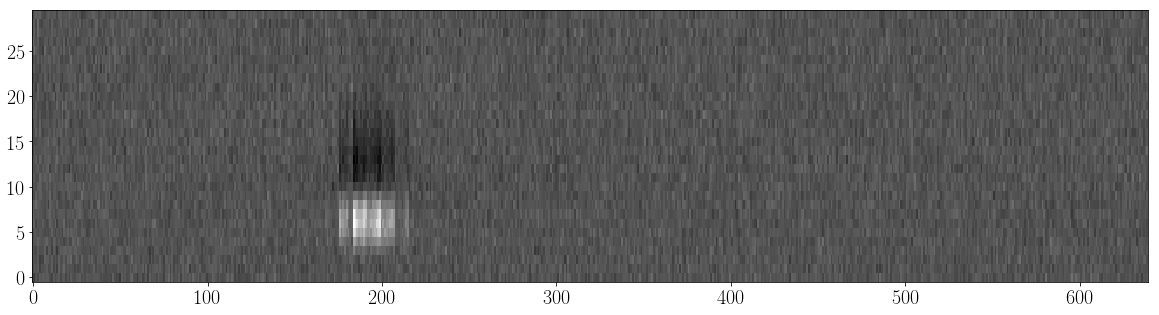

In [47]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(ridge_strf[:, :], cmap='gray')
ax.set_aspect('auto')

# Lasso CV

In [19]:
lasso_strf = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)

for window in range(n_frames_per_window):
    print(window)
    lasso = LassoCV(
        normalize=True,
        cv=5
    )
    lasso.fit(stims.T, responses_copy[:, 0])
    lasso_strf[window, :] = lasso.coef_.T
    print(r2_score(responses_copy[:, 0], lasso.predict(stims.T)))
    responses_copy = np.roll(responses_copy, -1, axis=0)

0
-2.220446049250313e-16
1
0.0002641984361620997
2
0.00014469765933899925
3
0.0008096645506809885
4
0.01017202935325956
5
0.027788089263994675
6
0.041849416153340036
7
0.03434676274070181
8
0.01483732587357256
9
0.0011414377986189717
10
0.0012768118316911492
11
0.005765089972815218
12
0.007962896004811038
13
0.009000556168423657
14
0.007437624345320359
15


KeyboardInterrupt: 

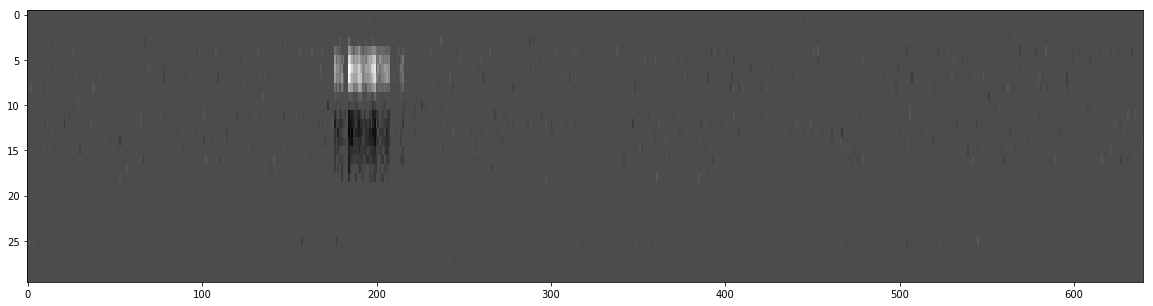

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(lasso_strf[:, :], cmap='gray')
ax.set_aspect('auto')

# UoI Lasso

In [10]:
# uoi lasso

uoi_strfs = np.zeros((n_frames_per_window, m))
responses_copy = np.copy(responses)[:, 0]

for window in range(n_frames_per_window):
    print(window)
    uoi = UoI_Lasso(
        n_lambdas=30,
        normalize=True,
        fit_intercept=True,
        estimation_score='r2',
        n_boots_sel=30,
        n_boots_est=30,
        selection_thres_min=1.0
    )
    uoi.fit(stims.T[:1000, :], responses_copy[:1000], verbose=True)
    uoi_strfs[window, :] = uoi.coef_.T
    responses_copy = np.roll(responses_copy, -1, axis=0)   

coarse lasso sweep:   0%|          | 0/10 [00:00<?, ?it/s]

0
(1) Loaded data.
 1000 samples with 640 features.


fine lasso sweep:   0%|          | 0/30 [00:00<?, ?it/s]

(2) Beginning model selection. Exploring penalty region centered at 4.78137e-08.


fine lasso sweep:   3%|▎         | 1/30 [00:00<00:10,  2.69it/s]


KeyboardInterrupt: 

In [11]:
uoi.lambdas

array([4.28137081e-08, 4.31585357e-08, 4.35033633e-08, 4.38481908e-08,
       4.41930184e-08, 4.45378460e-08, 4.48826736e-08, 4.52275012e-08,
       4.55723288e-08, 4.59171564e-08, 4.62619839e-08, 4.66068115e-08,
       4.69516391e-08, 4.72964667e-08, 4.76412943e-08, 4.79861219e-08,
       4.83309495e-08, 4.86757770e-08, 4.90206046e-08, 4.93654322e-08,
       4.97102598e-08, 5.00550874e-08, 5.03999150e-08, 5.07447426e-08,
       5.10895701e-08, 5.14343977e-08, 5.17792253e-08, 5.21240529e-08,
       5.24688805e-08, 5.28137081e-08])

In [27]:
# plotting
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}', '\\usepackage{amsmath}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'font.size': 30,
    'legend.fontsize': 10,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': True,
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)

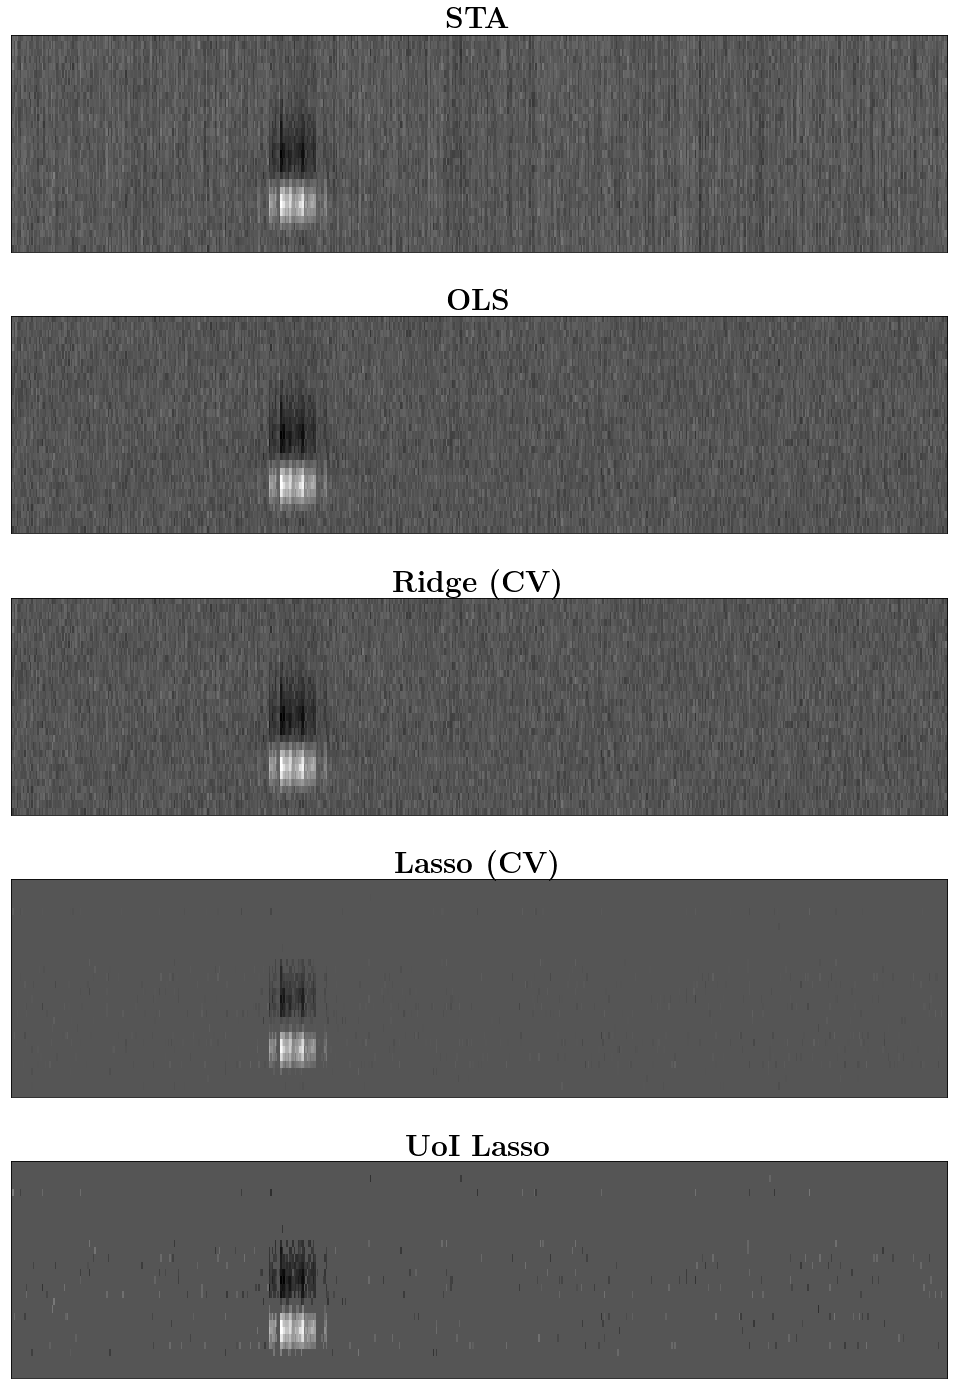

In [53]:
fig, axes = plt.subplots(5, 1, figsize=(14, 20))


axes[0].imshow(sta[:, :, 0], cmap='gray')
axes[0].set_title(r'\textbf{STA}')

axes[1].imshow(ols_strf, cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[1].set_title(r'\textbf{OLS}')

axes[2].imshow(ridge_strf, cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[2].set_title(r'\textbf{Ridge (CV)}')

axes[3].imshow(lasso_strf, cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[3].set_title(r'\textbf{Lasso (CV)}')

axes[4].imshow(uoi_strfs, cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[4].set_title(r'\textbf{UoI Lasso}')
                  
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    

plt.tight_layout()
plt.savefig('retina_strf.pdf')

In [35]:
np.count_nonzero(uoi_strfs)/np.count_nonzero(lasso_strf)

0.5518453427065027

In [34]:
np.count_nonzero(lasso_strf)

1138

In [57]:
np.max(sta[..., 0])

0.09172351654009527

In [40]:
uoi_strfs[:, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [58]:
from sklearn.metrics import r2_score
r2_score()

NameError: name 'r2_score' is not defined